In [1]:
# Regular Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import re

# Segmentation
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
IMAGE_PATH = "input/osic-pulmonary-fibrosis-progression/"

In [2]:
# read a dcm file for a particular patient
def read_dicom(patient_id, picture_id):
    dcm_file = IMAGE_PATH + 'train/' + str(patient_id) + '/' + str(picture_id) + '.dcm'
    return pydicom.read_file(dcm_file)

def get_all_patient_datasets(patient_id):
    patient_dir = IMAGE_PATH + "train/" + patient_id
    datasets = []

    # First Order the files in the dataset
    files = []
    for dcm in list(os.listdir(patient_dir)):
        files.append(dcm)
    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    # Read in the Dataset
    for dcm in files:
        path = patient_dir + "/" + dcm
        datasets.append(pydicom.dcmread(path))
    return datasets

def get_patient_id(dcm):
    return dcm[0x0010, 0x0020].value

def get_slice_location(dcm):
    return float(dcm[0x0020, 0x1041].value)

def get_pixel_spacings(dcm):
    """
    :param dcm:
    :return: list of two values: [row_spacing, column_spacing]
    """
    return dcm[0x0028, 0x0030].value

def get_slice_thickness(patient_id):
    dcm1 = read_dicom(patient_id, 1)
    dcm2 = read_dicom(patient_id, 2)
    return get_slice_location(dcm1) - get_slice_location(dcm2)

def get_square_mm_per_pixel(patient_id: str):
    dcm1 = read_dicom(patient_id, 1)
    spacings = get_pixel_spacings(dcm1)
    return spacings[0] * spacings[1]

In [3]:
def calculate_lung_volume(patient_id):
    datasets = get_all_patient_datasets(patient_id)
    total_lung_pixels = 0
    for i in range(1, len(datasets) +1):
        img = make_lungmask(datasets[i-1].pixel_array)
        lung_pixels = np.count_nonzero(img == 1)
        width, height = img.shape
        total_pixels = width * height
        total_lung_pixels += lung_pixels
        # print('{} Lung, {} Total, {} % Lung'.format(lung_pixels, total_pixels, (lung_pixels / total_pixels)))
    avg_slice_lung_pixels = total_lung_pixels/len(datasets)
    avg_slice_lung_area_mm = avg_slice_lung_pixels * get_square_mm_per_pixel(patient_id)
    lung_volume_mm3 = len(datasets) * get_slice_thickness(patient_id) * avg_slice_lung_area_mm
    lung_volume_cm3 = lung_volume_mm3 / 1000
    lung_volume_liter = lung_volume_cm3 / 1000
    print('Patient ID: ' + patient_id)
    print('Total Lung Pixels: ', total_lung_pixels)
    print('Average lung pixels: ', avg_slice_lung_pixels)
    print('Average lung area in mm²: ', avg_slice_lung_area_mm)
    print('Lung volume in cm³: ', lung_volume_cm3)
    print('Lung volume in liter: ', lung_volume_liter)
    print('###')
    return lung_volume_cm3

In [4]:
# https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]

    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std

    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)

    # To improve threshold finding, I'm moving the
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean

    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)

    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0


    #  After just the lungs are left, we do another large dilation in order to fill in and out the lung mask

    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')

        plt.show()
    #return mask*img
    return mask

In [5]:
# Plot the images
def plot_all_patient_images(patient_id, mask_type="plasma"):
    datasets = get_all_patient_datasets(patient_id)
    columns = 10
    rows = int(np.ceil(len(datasets) / 10))
    fig=plt.figure(figsize=(16, rows * 2))

    for i in range(1, columns*rows +1):
        img = datasets[i-1].pixel_array
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap=mask_type)
        plt.title(i, fontsize = 9)
        plt.axis('off')


In [6]:
# Show all masks of one picture
def show_all_masks(patient_id, picture_id):
    dataset = read_dicom(patient_id, picture_id)
    img = dataset.pixel_array
    # Masked image
    make_lungmask(img, display=True)

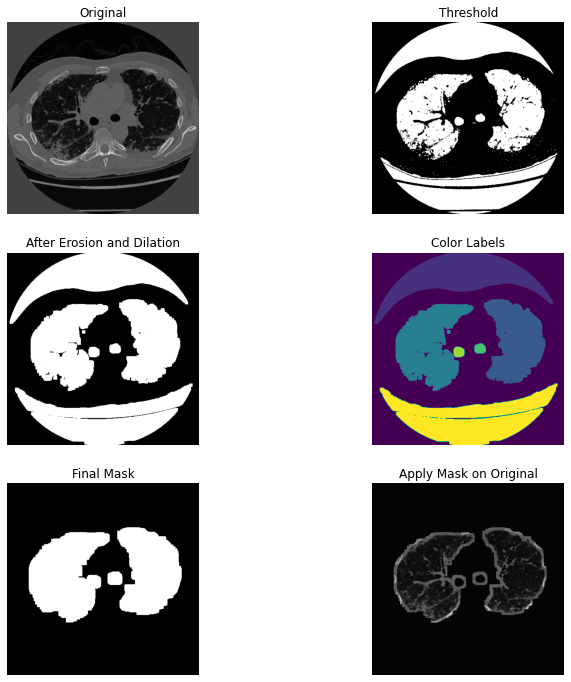

In [7]:
show_all_masks('ID00007637202177411956430', 14)

In [8]:
# plot_all_patient_images('ID00007637202177411956430', 'gray')

In [9]:
df_train = pd.read_csv(IMAGE_PATH + 'train.csv')
df_short = df_train.head()
print(df_short)
df_short['CtLungVolume'] = df_short.apply(lambda x: calculate_lung_volume(x['Patient']), axis=1)
df_short.head()
# calculate_lung_volume('ID00007637202177411956430')

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
Patient ID: ID00007637202177411956430
Total Lung Pixels:  1081215
Average lung pixels:  36040.5
Average lung area in mm²:  15337.13188021661
Lung volume in cm³:  4601.1395640649835
Lung volume in liter:  4.601139564064983
###
Patient ID: ID00007637202177411956430
Total Lung Pixels:  1079733
Average lung pixels:  35991.1
Average lung area in mm²:  15316.109577116411
Lung volume in cm³:  4594.832873134923
Lung volume in liter:  4.594832873134923
###
Patient ID: ID00007637202177411956430
Total Lung Pixels:  1080617
Average lung p

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,CtLungVolume
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,4601.139564
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,4594.832873
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,4598.594759
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,4598.560715
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,4604.288654
